In [1]:
"""traverse onnx model graph for visualization, requires `onnx` package, simplest version"""

'traverse onnx model graph for visualization, requires `onnx` package, simplest version'

In [2]:
from functools import wraps
import onnx
import nographs as nog
from graphviz import Digraph

In [3]:
onnx_model = onnx.load("inception_v4_no_w.onnx")

In [4]:
node_style ={"style": 'filled',            "shape": 'box',
             "align": 'left',              "fontsize": '12',
             "ranksep":'0.01',             "height":'0.02',   "width":'0.04',}
gr_style = {"linelength": '16', "rankdir": 'TB'}

def adapter_graphviz( wrapped_frw ):
    """translation to GraphViz visitor"""
    graph_dot = Digraph( node_attr = node_style, graph_attr = gr_style, )
    @wraps( wrapped_frw )
    def wrapper_bg_frw( vert, _traversal_context ):
        """visitor wrapper for folloing edge"""
        graph_dot.node( vert, vert )
        for result in wrapped_frw( vert, _traversal_context ):
            graph_dot.edge( vert, result[0], result[1], )
            yield result
    return wrapper_bg_frw, graph_dot

In [5]:
def locate_children( incoming_name ):
    "find target in onnx grapn by edge name "
    for child in onnx_model.graph.node:          # pylint: disable=no-member
        if incoming_name in set(child.input):
            yield (child.name, incoming_name)

def onnx_walk( nname, _ ):
    "returns successors of given vertex"
    if nname == '_GRAPH_INPUTS':
        for graph_in in onnx_model.graph.input:  # pylint: disable=no-member
            yield from locate_children( graph_in.name )
    else:
        for isnt_it_me in onnx_model.graph.node: # pylint: disable=no-member
            if nname == isnt_it_me.name:
                for node_output in isnt_it_me.output:
                    yield from locate_children( node_output )
                break

In [6]:
(f_1, dot) = adapter_graphviz( onnx_walk )

trav_b = nog.TraversalBreadthFirst( next_labeled_edges= f_1 )
trav_b.start_from( '_GRAPH_INPUTS' )
for _ in trav_b:
    pass

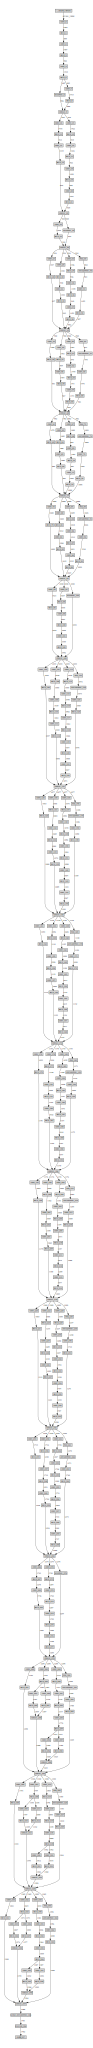

In [7]:
dot              # pylint: disable=pointless-statement